# 0) 환경 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#=====================구글 드라이브 경로 설정========================
%cd /content/drive/MyDrive/ColabNotebooks/team_project
#====================================================================

/content/drive/MyDrive/ColabNotebooks/team_project


In [3]:
!ls /content/drive/MyDrive/ColabNotebooks/team_project

 best_valid_model	       generated_No_DR_images
 checkpoints		       logs
 data			      'main(ipynb_py_파일변환_추가).ipynb'
'DCGAN_pytorch.ipynb의 사본'   retina_dataset.zip
 experiment_images	       retina.ipynb
 GAN_data		       src
 GAN_data.zip		       trainLabels.csv
 GAN_pytorch.ipynb	       VGG_Retina_ML.ipynb
 generated_DR_images


In [ ]:
#!unzip -qq "/content/drive/MyDrive/ColabNotebooks/team_project/GAN_data.zip"

# 1) Usage

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [5]:
latent_dim = 100


# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 3 * 224 * 224), # retina 224 & 224
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 224, 224) # channel, height, width
        return img

In [6]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(3 * 224 * 224, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

In [7]:
transforms_train = transforms.Compose([
    transforms.Resize(224), # 사이즈 
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#========================================훈련 데이터 저장 경로============================================================
train_dataset = datasets.ImageFolder(root="GAN_data/Retina_Some_binary/train/DR", transform=transforms_train)
#=========================================================================================================================

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [9]:
import time

n_epochs = 100 # 학습의 횟수(epoch) 설정
sample_interval = 25 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            #=======================================생성된 이미지 저장 경로=============================================
            save_image(generated_imgs.data[1], f"generated_DR_images/{done}.png", nrow=1, normalize=True)
            #===========================================================================================================
            
    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")


[Epoch 0/100] [D loss: 0.551939] [G loss: 0.499678] [Elapsed time: 442.28s]
[Epoch 1/100] [D loss: 0.595386] [G loss: 1.416674] [Elapsed time: 477.16s]
[Epoch 2/100] [D loss: 0.565664] [G loss: 0.548363] [Elapsed time: 512.08s]
[Epoch 3/100] [D loss: 0.540217] [G loss: 0.729877] [Elapsed time: 546.96s]
[Epoch 4/100] [D loss: 0.490126] [G loss: 0.924506] [Elapsed time: 581.82s]
[Epoch 5/100] [D loss: 0.578717] [G loss: 0.523375] [Elapsed time: 616.75s]
[Epoch 6/100] [D loss: 0.643179] [G loss: 0.643386] [Elapsed time: 651.72s]
[Epoch 7/100] [D loss: 0.528408] [G loss: 0.565516] [Elapsed time: 686.59s]
[Epoch 8/100] [D loss: 0.548104] [G loss: 0.684986] [Elapsed time: 721.53s]
[Epoch 9/100] [D loss: 0.475228] [G loss: 0.692921] [Elapsed time: 756.44s]
[Epoch 10/100] [D loss: 0.668620] [G loss: 1.219818] [Elapsed time: 791.34s]
[Epoch 11/100] [D loss: 0.740499] [G loss: 0.324136] [Elapsed time: 826.28s]
[Epoch 12/100] [D loss: 0.484523] [G loss: 0.650011] [Elapsed time: 861.24s]
[Epoch 13

(224, 224)


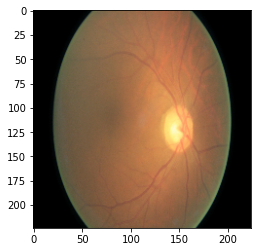

In [ ]:
img = Image.open('experiment_images/DR/44263_left.png')
print(img.size)
plt.imshow(np.asarray(img))


In [ ]:
imgs.shape[0]

10

(224, 224)


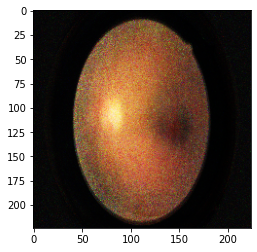

In [ ]:
gan_img = Image.open('GAN_image/0.png')
print(gan_img.size)
plt.imshow(np.asarray(gan_img))
